In [277]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords
import re
from sklearn.metrics import accuracy_score, recall_score, precision_score
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import cross_val_score

In [347]:
def train_pipeline():
    df = pd.read_csv('SMSSpamCollection', sep = '\t', names = ['Labels', 'Message'])
    analyse(df)
    df['Labels'] = labeling(df['Labels'])
    df['Message'] = text_preprocessing(df['Message'])
    vector = vectorizer(df.iloc[:,1], method = 'TF-IDF')
    new_df = pd.concat([df.drop(columns = df.columns[1]), pd.DataFrame(vector)], axis = 1)
    X_train, X_test, y_train, y_test = data_split(new_df, target = 'Labels')
    
    best_alpha = tree_pruning()
    classifier = DecisionTreeClassifier(ccp_alpha = best_alpha, criterion = 'entropy',
                                        random_state = 0, max_depth = 8)
    classifier.fit(X_train, y_train)
    
    val = Validation(classifier, X_train, X_test, y_train, y_test)

In [196]:
def analyse(df):
    spam = df[df['Labels'] == 'spam']['Labels'].count()
    not_spam = df[df['Labels'] == 'ham']['Labels'].count()


    def autopct(x, total):
        true = total * x / 100
        true = round(true, ndigits = 0)
        x = round(x, ndigits = 2)
        return '{0} records\n{1}%'.format(true,x)

    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(1,1,1)
    path, text, autotext = ax.pie(x = [spam, not_spam], labels = ['spam', 'not_spam'],
                                  colors = ['blue', 'green'], explode = [0.1, 0], shadow = True,
                                 autopct = lambda x: autopct(x, spam + not_spam), radius = 1, wedgeprops = {'width':0.8})
    ax.set_title('DATA DISTRIBUTION', color = 'white', fontsize = 20, loc = 'center')

    plt.setp(text, color = 'white', fontsize = 20, fontweight = 'bold', rotation = 30)
    plt.setp(autotext, color = 'white', fontsize = 14, fontweight = 'bold', rotation = 30)
    plt.show()

In [198]:
def labeling(data_to_label):
    encoder = LabelEncoder()
    data_to_label = encoder.fit_transform(data_to_label)
    return data_to_label
    

In [200]:
def text_preprocessing(text):
    sentences = []
    lem = WordNetLemmatizer()
    for i in text:
        sentences.append(re.sub('^[a-zA-Z]', ' ', i.lower()))
    
    for i in range(len(sentences)):
        tokens = nltk.word_tokenize(sentences[i])
        tokens = [lem.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
        sentences[i] = ' '.join(tokens)
    
    return sentences

In [201]:
df.iloc[:,1] = text_preprocessing(df.iloc[:,1])

In [202]:
def vectorizer(text, method = 'Bag_of_words'):
    template = {'Bag_of_words': CountVectorizer(), 'TF-IDF': TfidfVectorizer()}
    if method not in template.keys():
        print('Not appropriate method was choosen')
    else:
        text = np.array(text).reshape(1,-1)
        text = np.squeeze(text, axis = 0)
        vectorizer = template[method]  
        vector = vectorizer.fit_transform(text).toarray()
        return vector


In [208]:
vector= vectorizer(df.iloc[:,1], method = 'TF-IDF')

In [240]:
new_df = pd.concat([df.drop(columns = df.columns[1]), pd.DataFrame(vector)], axis = 1)

In [246]:
def data_split(df, target):
    X = df.drop(columns = target)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    return X_train, X_test, y_train, y_test    

In [275]:
class Validation:

    def __init__(self ,model , X_train, X_test, y_train, y_test):

        # dataset
        self.dataset = {'train': [X_train, y_train], 'test': [X_test, y_test]}

        # model
        self.model = model

        # model_parameters
        self.metrics = {'train': {'accuracy': 0, 'recall': 0, 'precision': 0},
                        'test': {'accuracy': 0, 'recall': 0, 'precision': 0}}
    
        self.start_validation()

    def dataset_validation(self, y, label):
        unique_values = {label: 0 for label in y.unique()}
        print('_________________________________________________________________')
        print('{0} set contain {1} unique labels'.format(label, len(unique_values)))

        for value in unique_values:
            unique_values[value] = y[y == value].count()

        for value in unique_values.keys():
            print('{0} - {1} record'.format(value, unique_values[value]))
        print('_________________________________________________________________')

    def model_validation(self):

        for data in self.dataset.keys():
            y_pred = self.model.predict(self.dataset[data][0])
            y_true = self.dataset[data][1]

            accuracy = self.k_fold_validation(X=self.dataset[data][0], y=self.dataset[data][1])
            precision = round(precision_score(y_true, y_pred) * 100, ndigits=2)
            recall = round(recall_score(y_true, y_pred) * 100, ndigits=2)

            self.metrics[data]['accuracy'] = accuracy
            self.metrics[data]['precision'] = precision
            self.metrics[data]['recall'] = recall
            print('_________________________________________________________________')
            print('For {0} data, accuracy = {1}%, precall = {2}%, recall = {3}%'.format(data, accuracy,
                                                                                        precision, recall))
            print('_________________________________________________________________')

    def k_fold_validation(self, X, y):
        accuracy = cross_val_score(estimator = self.model, X=X, y=y, cv=10, scoring='accuracy', n_jobs=-1)
        accuracy = round(accuracy.mean() * 100, ndigits=2)
        return accuracy

    def start_validation(self):
        start = time.time()
        self.dataset_validation(y=pd.Series(self.dataset['train'][1]), label='Train')
        self.dataset_validation(y=pd.Series(self.dataset['test'][1]), label='Test')
        self.model_validation()
        stop = time.time()
        total_time = stop - start
        print('Validation process took {0} s'.format(round(total_time, ndigits=3)))

In [344]:
def tree_pruning():
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, max_depth = 8)
    classifier.fit(X_train, y_train)
    
    path = classifier.cost_complexity_pruning_path(X = X_train, y = y_train)
    ccp_alphas = path['ccp_alphas']
    train_accuracy = []
    test_accuracy = []

    for alpha in ccp_alphas:
        temp_model = DecisionTreeClassifier(ccp_alpha = alpha, criterion = 'entropy',
                                            random_state = 0, max_depth = 8)
        temp_model.fit(X_train, y_train)
        train_accuracy.append(temp_model.score(X_train, y_train))
        test_accuracy.append(temp_model.score(X_test, y_test))
        
    fig = plt.figure(figsize = (12,12))
    ax = fig.add_subplot(1,1,1)
    ax.plot(ccp_alphas, train_accuracy, color = 'red', linestyle = '-', linewidth = 3,
            drawstyle = 'steps-post')
    ax.plot(ccp_alphas, test_accuracy, color = 'green', linestyle = '-', linewidth = 3,
            drawstyle = 'steps-post')

    ax.grid(linestyle = '--', color = 'black')

    ax.set_title('CCP_ALPHA DISTRIBUTION', color = 'white', fontsize = 20, fontweight = 'bold')
    ax.set_xticklabels([round(i, ndigits = 5) for i in ccp_alphas], color = 'white',
                       fontsize = 12, rotation = 45)
    plt.ylim(bottom = 0.94, top = 0.98)
    plt.show()
    
    
    best_alpha = None
    lowest_diff = float('inf')

    for i in range(len(ccp_alphas)):
        diff = abs(train_accuracy[i] - test_accuracy[i])
        if diff < lowest_diff:
            lowest_diff = diff
            best_alpha = ccp_alphas[i]
        else:
            continue
            
    print('The best ccp_alpha hyperparameters is {0}'.format(best_alpha))
    print('This value is going to be used while training')
    
    return best_alpha

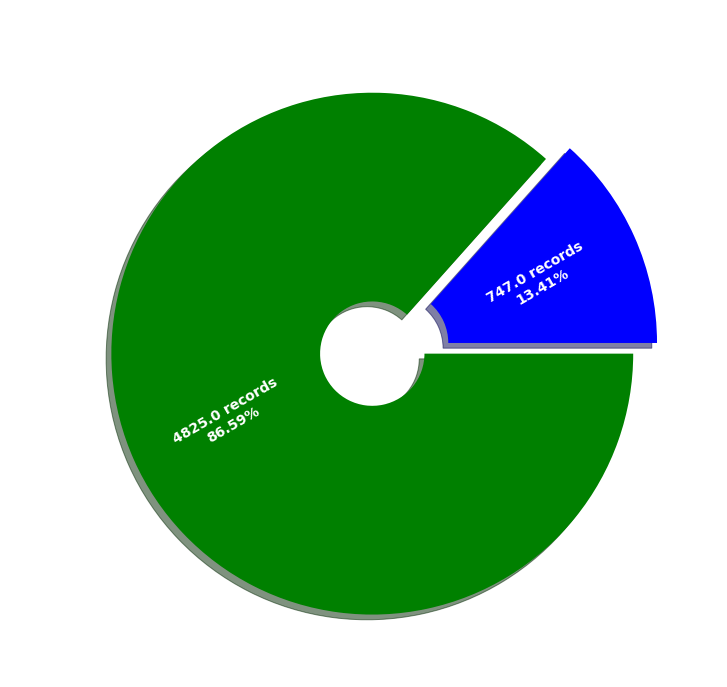

<ipython-input-344-b410757030a3>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([round(i, ndigits = 5) for i in ccp_alphas], color = 'white',


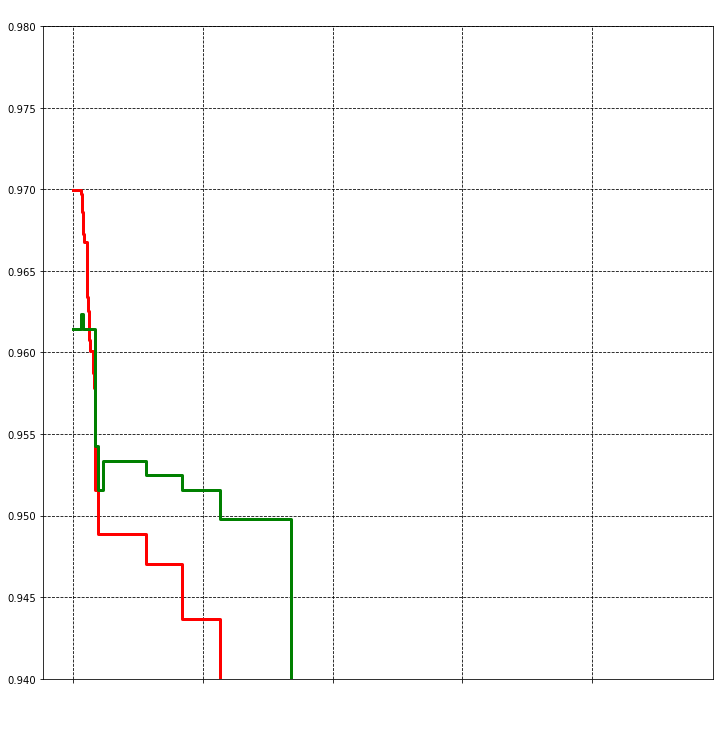

The best ccp_alpha hyperparameters is 0.0024732902966216434
This value is going to be used while training
_________________________________________________________________
Train set contain 2 unique labels
0 - 3870 record
1 - 587 record
_________________________________________________________________
_________________________________________________________________
Test set contain 2 unique labels
0 - 955 record
1 - 160 record
_________________________________________________________________
_________________________________________________________________
For train data, accuracy = 95.27%, precall = 95.37%, recall = 73.76%
_________________________________________________________________
_________________________________________________________________
For test data, accuracy = 94.8%, precall = 95.35%, recall = 76.88%
_________________________________________________________________
Validation process took 33.034 s


In [348]:
train_pipeline()